In [1]:
import numpy as np
from sklearn.model_selection import KFold
import random
import os
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
import torchvision
from torchvision import datasets,transforms,models
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import Subset

from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

from cnn_finetune import make_model
from sklearn.preprocessing import label_binarize
from itertools import cycle
import seaborn as sns

from sklearn.metrics import auc

from efficientnet_pytorch import EfficientNet


os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=4)
# Set all layers to trainable
for param in model.parameters():
    param.requires_grad = True  # Set to True for fine-tuning
model = model.to(device)

print(model)

Loaded pretrained weights for efficientnet-b0
EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d((0, 1, 0, 1))
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d((1, 1, 1, 1))
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kern

In [3]:
# データセットの設定
train_dataset = torchvision.datasets.ImageFolder(root='/home/yamaguchi/データセットまとめ完成版 β/GCB Non-GCB MALT Normal　完成版 - 最終/train')  # 学習用データセットのパス
test_dataset = torchvision.datasets.ImageFolder(root='/home/yamaguchi/データセットまとめ完成版 β/GCB Non-GCB MALT Normal　完成版 - 最終/test')  # テスト用データセットのパス

# 前処理の設定
transform = transforms.Compose([
    transforms.RandomCrop((224,224)),  # 画像をランダムにクロッピング
    transforms.RandomHorizontalFlip(),  # 画像をランダムに水平方向に反転
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # 画像の明るさとコントラストをランダムに変更
    transforms.Grayscale(num_output_channels=3),  # 画像をグレースケールに変換（3チャンネル出力）
    transforms.ToTensor(),  # 画像をTensorに変換
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 正規化
])

transform_2 = transforms.Compose([
    transforms.RandomCrop((224,224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# バッチサイズの設定
batch_size = 32

# 前処理の適用
train_dataset.transform = transform
test_dataset.transform = transform_2

# データローダーの設定
test_dataloader = DataLoader(test_dataset, batch_size, shuffle=False)

# クラス名の出力
print(train_dataset.classes)


['1 normal', '2 MALT', '3 GCB', '4 Non-GCB']


In [4]:
from torchsummary import summary

summary(model, (3, 224, 224))

#https://discuss.pytorch.org/t/what-is-1-in-output-shape-of-a-model-in-torch-summary/67790

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         ZeroPad2d-1          [-1, 3, 225, 225]               0
Conv2dStaticSamePadding-2         [-1, 32, 112, 112]             864
       BatchNorm2d-3         [-1, 32, 112, 112]              64
MemoryEfficientSwish-4         [-1, 32, 112, 112]               0
         ZeroPad2d-5         [-1, 32, 114, 114]               0
Conv2dStaticSamePadding-6         [-1, 32, 112, 112]             288
       BatchNorm2d-7         [-1, 32, 112, 112]              64
MemoryEfficientSwish-8         [-1, 32, 112, 112]               0
          Identity-9             [-1, 32, 1, 1]               0
Conv2dStaticSamePadding-10              [-1, 8, 1, 1]             264
MemoryEfficientSwish-11              [-1, 8, 1, 1]               0
         Identity-12              [-1, 8, 1, 1]               0
Conv2dStaticSamePadding-13             [-1, 32, 1, 1]             288
         I

In [5]:
def train(device, model, optimizer, criterion, cv_train_dataloader, cv_valid_dataloader):
    # Early stoppingのためのパラメータ設定
    the_last_loss = 100  # 比較の基準となる初期損失値
    patience = 10  # 耐性回数：この回数だけ損失の改善が見られない場合、訓練を停止
    trigger_times = 0  # 連続で損失の改善が見られなかった回数を記録

    # エポック数だけ訓練を繰り返す
    for epoch in range(100):
        model.train()  # モデルを訓練モードに設定
        running_loss = 0.0
        correct_num = 0
        total_num = 0
        batch_count = 0

        # 訓練データローダーからバッチ単位でデータを取得し、訓練を実行
        for data, target in cv_train_dataloader:
            inputs, labels = data.to(device), target.to(device)  # データをデバイスに転送

            optimizer.zero_grad()  # 勾配を0に初期化

            outputs = model(inputs)  # モデルで予測
            
            loss = criterion(outputs, labels)  # 損失の計算
            predicted = torch.max(outputs.data, 1)[1]
            correct_num_temp = (predicted == labels).sum()
            correct_num += correct_num_temp.item()
            total_num += data.shape[0]
            loss.backward()  # 勾配の計算
            optimizer.step()  # パラメータの更新
            running_loss += loss.item()
            batch_count += 1

        print('epoch:%d loss: %.3f acc: %.3f' %
              (epoch + 1, running_loss / batch_count, correct_num * 100 / total_num))

        # 検証データによる早期停止のチェック
        the_current_loss = validation(model, device, cv_valid_dataloader, criterion)
        print('The current loss:', the_current_loss)

        # 損失が前回よりも大きい場合はトリガーカウントを増やす
        if the_current_loss > the_last_loss:
            trigger_times += 1
            print('trigger times:', trigger_times)

            # トリガーカウントがpatienceを超えた場合、早期停止
            if trigger_times >= patience:
                print('Early stopping!\nStart to test process.')
                return model

        else:
            print('trigger times: 0')
            trigger_times = 0  # 損失が改善した場合はトリガーカウントをリセット

        the_last_loss = the_current_loss  # 最後の損失値を更新

    return model  # 訓練が終了したモデルを返す


In [6]:
def validation(model, device, cv_valid_dataloader, criterion):
    model.eval()  # モデルを評価モードに設定
    running_loss = 0

    with torch.no_grad():  # 勾配計算を行わない
        for data, target in cv_valid_dataloader:
            inputs, labels = data.to(device), target.to(device)  # データをデバイスに転送

            outputs = model(inputs)  # モデルで予測
            loss = criterion(outputs, labels)  # 損失の計算
            running_loss += loss.item()  # 損失を加算

    # 平均損失を計算して返す
    return running_loss / len(cv_valid_dataloader)


In [7]:

def test(device, model, test_dataloader):
    model.eval()
    
    correct_num = 0
    total_num = 0
    predicts_list = []
    labels_list = []
    scores_list=[] 

    with torch.no_grad():
        for data, target in test_dataloader:
            inputs, labels = data.to(device), target.to(device)

            outputs = model(inputs)
            m = nn.Softmax(dim=1)
            probs = m(outputs)
            
            _, predicted = torch.max(outputs.data, 1)
            correct_num_temp = (predicted == labels).sum()
            correct_num += correct_num_temp.item()
            total_num += data.shape[0]

            device2 = torch.device('cpu')
            labels=labels.to(device2)
            predicted = predicted.to(device2)
            probs = probs.to(device2)

            labels_list.append(labels)
            predicts_list.append(predicted)
            scores_list.append(probs)  
    
        labels = torch.cat(labels_list)
        predicted = torch.cat(predicts_list)
        scores = torch.cat(scores_list)  

        labels_bin = label_binarize(labels, classes=[0, 1, 2, 3])  # Changed to four classes

        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(4):  # Changed loop range to four classes
            fpr[i], tpr[i], _ = roc_curve(labels_bin[:, i], scores[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        C = confusion_matrix(labels, predicted)
        ac = accuracy_score(labels, predicted)
        pre = precision_score(labels, predicted, average='macro')
        re = recall_score(labels, predicted, average='macro')
        f1 = f1_score(labels, predicted, average='macro')

        AUC = roc_auc_score(labels, scores, multi_class='ovr')  

        print(C)
        print("\n")
        print("test accuracy : %.3f" % ac)
        print("test precison : %.3f" % pre)
        print("test recall : %.3f" % re)
        print("test f : %.3f" % f1)
        print("AUC : %.3f" %(AUC))

        for i in range(4):  # Changed loop range to four classes
            print("AUC for class {}: {:.3f}".format(i, roc_auc[i]))

        # Compute macro-average ROC curve and ROC area
        fpr_macro = dict()
        tpr_macro = dict()
        roc_auc_macro = dict()
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(4)]))  # Changed loop range to four classes
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(4):  # Changed loop range to four classes
            mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
        mean_tpr /= 4  # Changed the denominator to four classes
        fpr_macro["macro"] = all_fpr
        tpr_macro["macro"] = mean_tpr
        roc_auc_macro["macro"] = auc(fpr_macro["macro"], tpr_macro["macro"])

        # Plot all ROC curves
        plt.figure()
        plt.plot(fpr_macro["macro"], tpr_macro["macro"],
                 label='macro-average ROC curve (area = {:.3g})'.format(roc_auc_macro["macro"]),
                 color='navy', linestyle=':', linewidth=4)

        colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red'])  # Added one more color for the additional class
        class_labels = ['normal lymph nodes', 'MALToma', 'GCB', 'non-GCB']  # Changed to four class labels
        for i, color in zip(range(4), colors):  # Changed loop range to four classes
            plt.plot(fpr[i], tpr[i], color=color, lw=2,
                     label='ROC curve of class {0} (area = {1:.3g})'
                     ''.format(class_labels[i], roc_auc[i]))

            
        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Some extension of Receiver operating characteristic to multi-class')
        plt.legend(loc="lower right")
        
        class_labels = ['normal lymph nodes', 'MALToma', 'GCB', 'non-GCB']   # Changed to four class labels
        C = confusion_matrix(labels, predicted)

        # Plot confusion matrix
        plt.figure(figsize=(8, 6))
        sns.heatmap(C, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels, annot_kws={'size': 20})  # ここでフォントサイズを12に設定
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.title('Confusion Matrix')
        plt.show()
        plt.show()

            

In [8]:
#k分割交差検証

kf = KFold(n_splits=10)

Loaded pretrained weights for efficientnet-b0
Fold 1------------------------------------------------------------------------------
epoch:1 loss: 0.978 acc: 59.245
The current loss: 1.1378452410388484
trigger times: 0
epoch:2 loss: 0.783 acc: 66.750
The current loss: 0.7119112808674926
trigger times: 0
epoch:3 loss: 0.675 acc: 71.596
The current loss: 0.6560734048881361
trigger times: 0
epoch:4 loss: 0.596 acc: 75.796
The current loss: 0.5572551083242779
trigger times: 0
epoch:5 loss: 0.531 acc: 79.184
The current loss: 0.42594517094212253
trigger times: 0
epoch:6 loss: 0.484 acc: 80.772
The current loss: 0.3781194596195588
trigger times: 0
epoch:7 loss: 0.427 acc: 82.618
The current loss: 0.3977745274235673
trigger times: 1
epoch:8 loss: 0.385 acc: 84.972
The current loss: 0.3287834978448145
trigger times: 0
epoch:9 loss: 0.341 acc: 86.781
The current loss: 0.25845136996468526
trigger times: 0
epoch:10 loss: 0.319 acc: 87.270
The current loss: 0.21787194529195264
trigger times: 0
epoch

epoch:92 loss: 0.015 acc: 99.520
The current loss: 0.0013058291802480223
trigger times: 0
epoch:93 loss: 0.019 acc: 99.400
The current loss: 0.0018288327711361108
trigger times: 1
epoch:94 loss: 0.017 acc: 99.326
The current loss: 0.002462538526873677
trigger times: 2
epoch:95 loss: 0.017 acc: 99.418
The current loss: 0.0009582072915493107
trigger times: 0
epoch:96 loss: 0.012 acc: 99.668
The current loss: 0.044281519270504034
trigger times: 1
epoch:97 loss: 0.015 acc: 99.511
The current loss: 0.004486099804226198
trigger times: 0
epoch:98 loss: 0.016 acc: 99.446
The current loss: 0.0019359843640702258
trigger times: 0
epoch:99 loss: 0.015 acc: 99.502
The current loss: 0.0015427819148364967
trigger times: 0
epoch:100 loss: 0.015 acc: 99.520
The current loss: 0.000708852424316552
trigger times: 0
[[137   4   6   3]
 [  0 119   1   2]
 [  0   0  63 147]
 [  1   0 123 356]]


test accuracy : 0.702
test precison : 0.747
test recall : 0.733
test f : 0.739
AUC : 0.864
AUC for class 0: 0.999


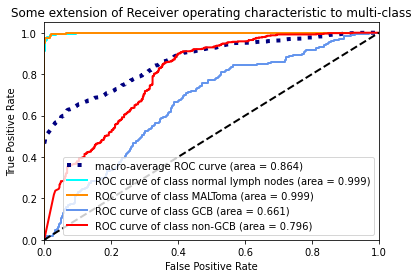

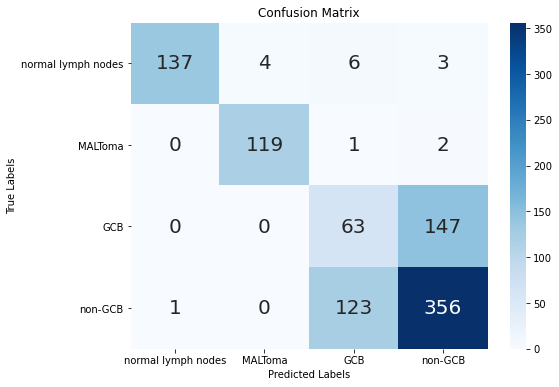

Loaded pretrained weights for efficientnet-b0
Fold 2------------------------------------------------------------------------------
epoch:1 loss: 0.970 acc: 59.725
The current loss: 1.026357030534463
trigger times: 0
epoch:2 loss: 0.782 acc: 66.897
The current loss: 0.8769945304643
trigger times: 0
epoch:3 loss: 0.692 acc: 71.245
The current loss: 0.6220932642827607
trigger times: 0
epoch:4 loss: 0.598 acc: 75.381
The current loss: 0.5530578519291847
trigger times: 0
epoch:5 loss: 0.535 acc: 78.316
The current loss: 0.4604946884318395
trigger times: 0
epoch:6 loss: 0.480 acc: 80.818
The current loss: 0.43494657889437094
trigger times: 0
epoch:7 loss: 0.441 acc: 82.396
The current loss: 0.5152335803815683
trigger times: 1
epoch:8 loss: 0.391 acc: 84.243
The current loss: 0.5347227325867642
trigger times: 2
epoch:9 loss: 0.362 acc: 85.747
The current loss: 0.3082282832702814
trigger times: 0
epoch:10 loss: 0.326 acc: 87.381
The current loss: 0.27147698131215464
trigger times: 0
epoch:11 l

The current loss: 0.0012714494209506923
trigger times: 1
epoch:93 loss: 0.019 acc: 99.372
The current loss: 0.0009013474778277967
trigger times: 0
epoch:94 loss: 0.019 acc: 99.354
The current loss: 0.0022583488505756918
trigger times: 1
epoch:95 loss: 0.014 acc: 99.575
The current loss: 0.0013166894252358283
trigger times: 0
epoch:96 loss: 0.012 acc: 99.668
The current loss: 0.0007094409841386724
trigger times: 0
epoch:97 loss: 0.015 acc: 99.483
The current loss: 0.0008303926196757807
trigger times: 1
epoch:98 loss: 0.015 acc: 99.465
The current loss: 0.0013784701785825232
trigger times: 2
epoch:99 loss: 0.017 acc: 99.465
The current loss: 0.0011718162467820664
trigger times: 0
epoch:100 loss: 0.016 acc: 99.465
The current loss: 0.0008496441658464544
trigger times: 0
[[130  10   9   1]
 [  0 118   0   4]
 [  0   0  70 140]
 [  0   0  78 402]]


test accuracy : 0.748
test precison : 0.776
test recall : 0.751
test f : 0.759
AUC : 0.871
AUC for class 0: 0.999
AUC for class 1: 0.999
AUC fo

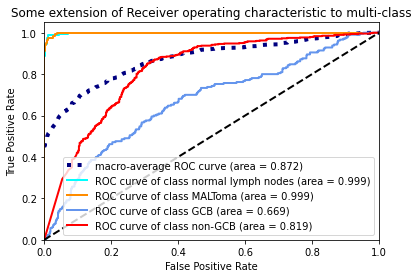

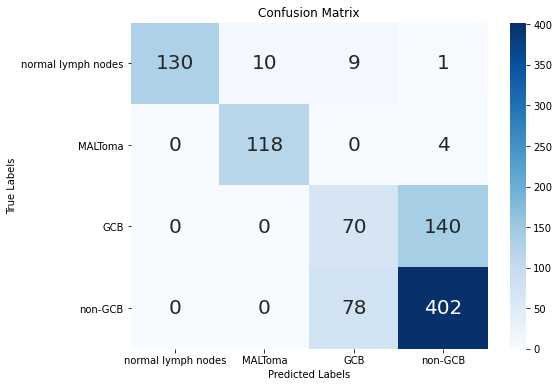

Loaded pretrained weights for efficientnet-b0
Fold 3------------------------------------------------------------------------------
epoch:1 loss: 0.983 acc: 58.866
The current loss: 0.8843699336315678
trigger times: 0
epoch:2 loss: 0.789 acc: 66.704
The current loss: 0.7573386332498188
trigger times: 0
epoch:3 loss: 0.685 acc: 70.968
The current loss: 0.6322709148815644
trigger times: 0
epoch:4 loss: 0.604 acc: 74.753
The current loss: 0.520578732131637
trigger times: 0
epoch:5 loss: 0.537 acc: 78.584
The current loss: 0.5605896730745172
trigger times: 1
epoch:6 loss: 0.476 acc: 81.169
The current loss: 0.42037487869867973
trigger times: 0
epoch:7 loss: 0.436 acc: 82.304
The current loss: 0.3347911295854654
trigger times: 0
epoch:8 loss: 0.401 acc: 84.215
The current loss: 0.3331494131084301
trigger times: 0
epoch:9 loss: 0.353 acc: 86.310
The current loss: 0.28071556430121825
trigger times: 0
epoch:10 loss: 0.318 acc: 87.769
The current loss: 0.6511793876957777
trigger times: 1
epoch:1

The current loss: 0.0009372795446336356
trigger times: 0
epoch:93 loss: 0.017 acc: 99.492
The current loss: 0.0012567211015278943
trigger times: 1
epoch:94 loss: 0.018 acc: 99.428
The current loss: 0.0005109403587330898
trigger times: 0
epoch:95 loss: 0.016 acc: 99.502
The current loss: 0.0008019291592289667
trigger times: 1
epoch:96 loss: 0.015 acc: 99.557
The current loss: 0.005525856492129835
trigger times: 2
epoch:97 loss: 0.014 acc: 99.585
The current loss: 0.00046615003101366063
trigger times: 0
epoch:98 loss: 0.015 acc: 99.437
The current loss: 0.0017153732583304257
trigger times: 1
epoch:99 loss: 0.014 acc: 99.529
The current loss: 0.001091828131347301
trigger times: 0
epoch:100 loss: 0.014 acc: 99.529
The current loss: 0.0007389574693581139
trigger times: 0
[[135   9   4   2]
 [  0 118   0   4]
 [  0   0  70 140]
 [  2   0  98 380]]


test accuracy : 0.731
test precison : 0.761
test recall : 0.748
test f : 0.753
AUC : 0.872
AUC for class 0: 0.997
AUC for class 1: 0.999
AUC for

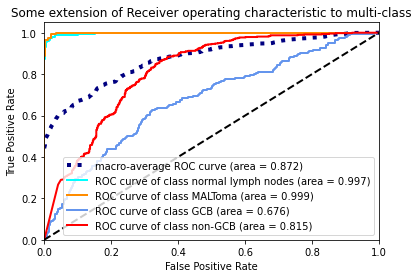

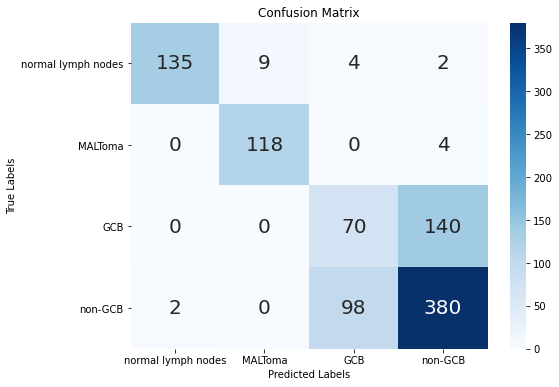

Loaded pretrained weights for efficientnet-b0
Fold 4------------------------------------------------------------------------------
epoch:1 loss: 0.976 acc: 59.042
The current loss: 1.2013391537212692
trigger times: 0
epoch:2 loss: 0.789 acc: 66.796
The current loss: 0.7095244826644571
trigger times: 0
epoch:3 loss: 0.680 acc: 71.531
The current loss: 0.6541489237661207
trigger times: 0
epoch:4 loss: 0.600 acc: 75.824
The current loss: 0.5454007323534615
trigger times: 0
epoch:5 loss: 0.520 acc: 78.972
The current loss: 0.4488186061404272
trigger times: 0
epoch:6 loss: 0.473 acc: 81.104
The current loss: 0.40108619864128947
trigger times: 0
epoch:7 loss: 0.426 acc: 82.913
The current loss: 0.3651878493219878
trigger times: 0
epoch:8 loss: 0.395 acc: 84.243
The current loss: 0.4888620803099686
trigger times: 1
epoch:9 loss: 0.363 acc: 85.636
The current loss: 0.2646197862847596
trigger times: 0
epoch:10 loss: 0.320 acc: 87.353
The current loss: 0.2842962289696757
trigger times: 1
epoch:1

epoch:92 loss: 0.019 acc: 99.437
The current loss: 0.000856524559383436
trigger times: 0
epoch:93 loss: 0.013 acc: 99.557
The current loss: 0.0010760936283515695
trigger times: 1
epoch:94 loss: 0.014 acc: 99.585
The current loss: 0.0010654529961466135
trigger times: 0
epoch:95 loss: 0.015 acc: 99.474
The current loss: 0.0008607403001185524
trigger times: 0
epoch:96 loss: 0.015 acc: 99.492
The current loss: 0.001138407051563609
trigger times: 1
epoch:97 loss: 0.015 acc: 99.529
The current loss: 0.0010325815792372097
trigger times: 0
epoch:98 loss: 0.013 acc: 99.658
The current loss: 0.0006894210777715978
trigger times: 0
epoch:99 loss: 0.013 acc: 99.594
The current loss: 0.0011549217220426444
trigger times: 1
epoch:100 loss: 0.013 acc: 99.603
The current loss: 0.0005683930683038107
trigger times: 0
[[125  17   8   0]
 [  0 121   0   1]
 [  0   0  57 153]
 [  2   0  83 395]]


test accuracy : 0.726
test precison : 0.741
test recall : 0.730
test f : 0.730
AUC : 0.857
AUC for class 0: 0.99

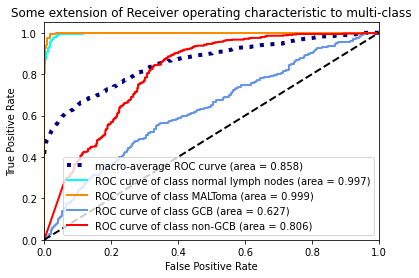

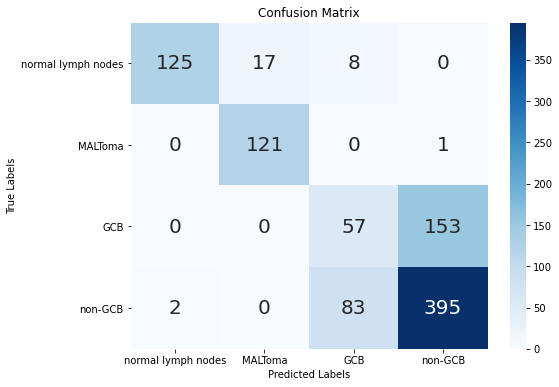

Loaded pretrained weights for efficientnet-b0
Fold 5------------------------------------------------------------------------------
epoch:1 loss: 0.978 acc: 58.913
The current loss: 0.9472502564302588
trigger times: 0
epoch:2 loss: 0.783 acc: 67.387
The current loss: 0.6927805404703525
trigger times: 0
epoch:3 loss: 0.687 acc: 71.587
The current loss: 0.6401401028383227
trigger times: 0
epoch:4 loss: 0.598 acc: 75.538
The current loss: 0.5558349076235408
trigger times: 0
epoch:5 loss: 0.535 acc: 78.510
The current loss: 0.44319819939078264
trigger times: 0
epoch:6 loss: 0.473 acc: 80.799
The current loss: 0.40470933719540897
trigger times: 0
epoch:7 loss: 0.428 acc: 83.135
The current loss: 0.5854911921988173
trigger times: 1
epoch:8 loss: 0.390 acc: 84.344
The current loss: 0.3556712134658829
trigger times: 0
epoch:9 loss: 0.355 acc: 86.449
The current loss: 0.3637928410943537
trigger times: 1
epoch:10 loss: 0.327 acc: 87.224
The current loss: 0.32323049250742897
trigger times: 0
epoch

The current loss: 0.012610207318235136
trigger times: 2
epoch:93 loss: 0.019 acc: 99.465
The current loss: 0.005811578628298897
trigger times: 0
epoch:94 loss: 0.018 acc: 99.391
The current loss: 0.0009844205766365362
trigger times: 0
epoch:95 loss: 0.015 acc: 99.520
The current loss: 0.017154938351274428
trigger times: 1
epoch:96 loss: 0.015 acc: 99.548
The current loss: 0.0014417968356174329
trigger times: 0
epoch:97 loss: 0.016 acc: 99.483
The current loss: 0.0006645197300860327
trigger times: 0
epoch:98 loss: 0.015 acc: 99.603
The current loss: 0.0005673768997937941
trigger times: 0
epoch:99 loss: 0.016 acc: 99.492
The current loss: 0.0008439009340955298
trigger times: 1
epoch:100 loss: 0.017 acc: 99.400
The current loss: 0.0008919816245539349
trigger times: 2
[[125  12   8   5]
 [  0 112   0  10]
 [  1   0  77 132]
 [  0   0 135 345]]


test accuracy : 0.685
test precison : 0.737
test recall : 0.709
test f : 0.721
AUC : 0.848
AUC for class 0: 0.998
AUC for class 1: 0.996
AUC for c

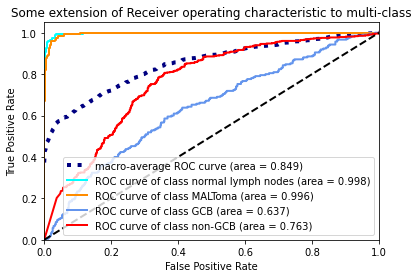

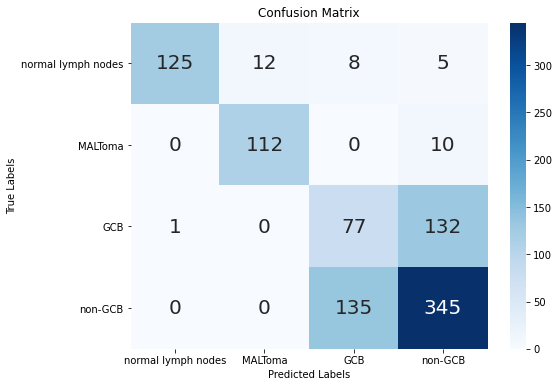

Loaded pretrained weights for efficientnet-b0
Fold 6------------------------------------------------------------------------------
epoch:1 loss: 0.973 acc: 59.420
The current loss: 0.9541603703941919
trigger times: 0
epoch:2 loss: 0.780 acc: 67.257
The current loss: 0.7481828667772906
trigger times: 0
epoch:3 loss: 0.671 acc: 72.261
The current loss: 0.689995704122591
trigger times: 0
epoch:4 loss: 0.585 acc: 75.999
The current loss: 0.5282757400307024
trigger times: 0
epoch:5 loss: 0.512 acc: 79.332
The current loss: 0.5739205755117545
trigger times: 1
epoch:6 loss: 0.471 acc: 81.076
The current loss: 0.4915930970810947
trigger times: 0
epoch:7 loss: 0.417 acc: 83.587
The current loss: 0.9815572289809046
trigger times: 1
epoch:8 loss: 0.380 acc: 84.981
The current loss: 0.2908965909872808
trigger times: 0
epoch:9 loss: 0.347 acc: 86.421
The current loss: 0.24825655169658647
trigger times: 0
epoch:10 loss: 0.322 acc: 87.630
The current loss: 0.23215945149293846
trigger times: 0
epoch:1

epoch:92 loss: 0.016 acc: 99.520
The current loss: 0.0008356936354674239
trigger times: 0
epoch:93 loss: 0.015 acc: 99.520
The current loss: 0.0007557025075428901
trigger times: 0
epoch:94 loss: 0.016 acc: 99.465
The current loss: 0.0026325573012368477
trigger times: 1
epoch:95 loss: 0.017 acc: 99.474
The current loss: 0.001771041388255418
trigger times: 0
epoch:96 loss: 0.014 acc: 99.566
The current loss: 0.00048695526247928
trigger times: 0
epoch:97 loss: 0.013 acc: 99.612
The current loss: 0.0006271494553898909
trigger times: 1
epoch:98 loss: 0.013 acc: 99.603
The current loss: 0.0006880259985985153
trigger times: 2
epoch:99 loss: 0.014 acc: 99.566
The current loss: 0.0009163152689135308
trigger times: 3
epoch:100 loss: 0.014 acc: 99.538
The current loss: 0.002123921742714742
trigger times: 4
[[117  17   8   8]
 [  0 117   1   4]
 [  2   0  75 133]
 [  0   0 128 352]]


test accuracy : 0.687
test precison : 0.730
test recall : 0.707
test f : 0.715
AUC : 0.860
AUC for class 0: 0.992


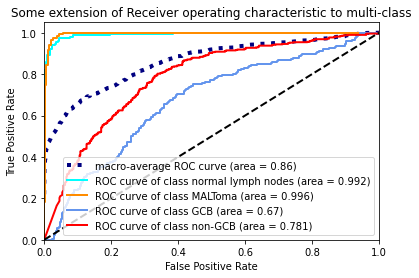

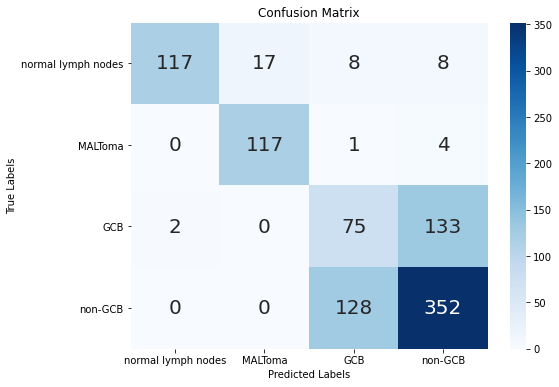

Loaded pretrained weights for efficientnet-b0
Fold 7------------------------------------------------------------------------------
epoch:1 loss: 0.984 acc: 58.349
The current loss: 0.9915630681808367
trigger times: 0
epoch:2 loss: 0.788 acc: 66.999
The current loss: 0.7270918352622814
trigger times: 0
epoch:3 loss: 0.679 acc: 71.698
The current loss: 0.8301923714391338
trigger times: 1
epoch:4 loss: 0.597 acc: 74.965
The current loss: 0.5533368747109948
trigger times: 0
epoch:5 loss: 0.533 acc: 78.289
The current loss: 0.5171133622590309
trigger times: 0
epoch:6 loss: 0.482 acc: 80.292
The current loss: 0.3916692123336272
trigger times: 0
epoch:7 loss: 0.430 acc: 82.452
The current loss: 0.6778989517443146
trigger times: 1
epoch:8 loss: 0.381 acc: 84.695
The current loss: 0.3278650296927542
trigger times: 0
epoch:9 loss: 0.353 acc: 85.849
The current loss: 0.2596970506295408
trigger times: 0
epoch:10 loss: 0.326 acc: 87.132
The current loss: 0.21470108468450913
trigger times: 0
epoch:1

epoch:92 loss: 0.021 acc: 99.354
The current loss: 0.0008210318500783289
trigger times: 0
epoch:93 loss: 0.016 acc: 99.437
The current loss: 0.002194793795997531
trigger times: 1
epoch:94 loss: 0.015 acc: 99.511
The current loss: 0.0009773934212440492
trigger times: 0
epoch:95 loss: 0.017 acc: 99.409
The current loss: 0.0008174853504217848
trigger times: 0
epoch:96 loss: 0.015 acc: 99.474
The current loss: 0.0007197514606134807
trigger times: 0
epoch:97 loss: 0.015 acc: 99.548
The current loss: 0.0018520990242776826
trigger times: 1
epoch:98 loss: 0.015 acc: 99.483
The current loss: 0.0016721214969855408
trigger times: 0
epoch:99 loss: 0.015 acc: 99.492
The current loss: 0.000964571152556476
trigger times: 0
epoch:100 loss: 0.019 acc: 99.372
The current loss: 0.0013834032178573167
trigger times: 1
[[139   2   8   1]
 [  0  98   3  21]
 [  2   1  56 151]
 [  0   0 117 363]]


test accuracy : 0.682
test precison : 0.734
test recall : 0.688
test f : 0.708
AUC : 0.844
AUC for class 0: 1.00

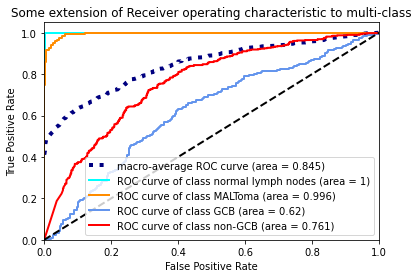

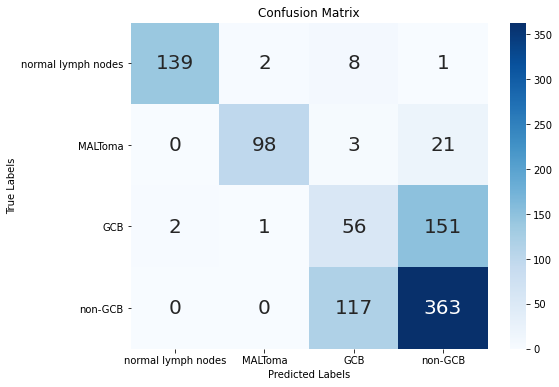

Loaded pretrained weights for efficientnet-b0
Fold 8------------------------------------------------------------------------------
epoch:1 loss: 0.969 acc: 59.282
The current loss: 1.1250090580598442
trigger times: 0
epoch:2 loss: 0.771 acc: 67.848
The current loss: 0.7112724595321315
trigger times: 0
epoch:3 loss: 0.675 acc: 71.725
The current loss: 0.5907653198085704
trigger times: 0
epoch:4 loss: 0.591 acc: 75.685
The current loss: 0.5746624488218696
trigger times: 0
epoch:5 loss: 0.520 acc: 78.861
The current loss: 0.45986928674186356
trigger times: 0
epoch:6 loss: 0.480 acc: 80.836
The current loss: 0.4270745449731055
trigger times: 0


KeyboardInterrupt: 

In [9]:
%%time

def main():
    
    for _fold, (train_index, valid_index) in enumerate(kf.split(np.arange(len(train_dataset)))):
    
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        
        model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=4)
        # Set all layers to trainable
        for param in model.parameters():
            param.requires_grad = True  # Set to True for fine-tuning
        model = model.to(device)

        batch_size = 32
        criterion = nn.CrossEntropyLoss()
        # Pass all model parameters to the optimizer
        optimizer = optim.SGD(model.parameters(), lr=0.001,momentum=0.9) # Optimize the entire model for fine-tuning
        
        cv_train_dataset = Subset(train_dataset, train_index)
        cv_train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True)
        cv_valid_dataset   = Subset(train_dataset, valid_index)
        cv_valid_dataloader = DataLoader(train_dataset, batch_size, shuffle=False)
        
        print('Fold {}------------------------------------------------------------------------------'.format(_fold+1))

        model = train(device, model, optimizer, criterion, cv_train_dataloader, cv_valid_dataloader)
        test(device, model, test_dataloader)


if __name__ == '__main__':
    main()